# Diffusion Models

Mazu Sea is a Diffusion based Artificial Intelligence. The code is adapted from two sources:
* ['Denoising Diffusion Implicit Models' tutorial](https://keras.io/examples/generative/ddim/) by András Béres available on the Keras website.
* Generative Deep Learning, 2nd edition, by David Foster (O’Reilly), 2023.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import math

# import keras
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    utils,
    callbacks,
    metrics,
    losses,
    activations,
)

from notebooks.utils import display, sample_batch

2024-05-08 10:48:33.976548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 10:48:34.761828: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Parameters <a name="parameters"></a>

In [22]:
IMAGE_SIZE = 256
BATCH_SIZE = 12
# DATASET_REPETITIONS = 5
DATASET_REPETITIONS = 1
LOAD_MODEL = True

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 1

## Prepare the Data

In [3]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/app/data/skrea-video",
    labels=None,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 22666 files belonging to 1 classes.


2024-05-08 10:48:45.631863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 10:48:45.657186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 10:48:45.658165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 10:48:45.662735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [4]:
# Preprocess the data
def preprocess(img):
    # normalise image
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))
train = train.repeat(DATASET_REPETITIONS)
train = train.batch(BATCH_SIZE, drop_remainder=True)

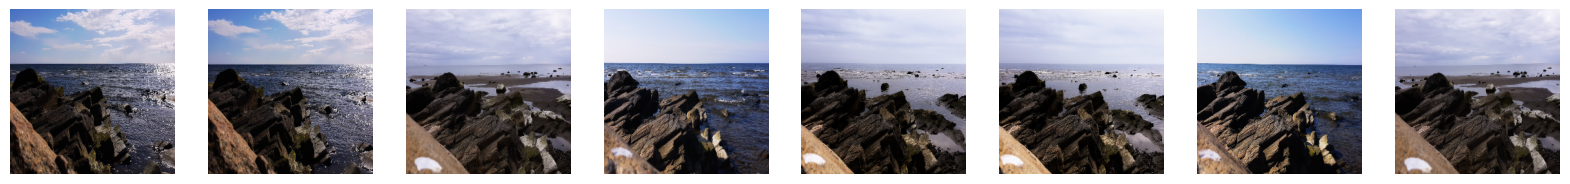

In [6]:
# Show some images from the training set
train_sample = sample_batch(train)
display(train_sample)

### Diffusion schedule

In [7]:
# def linear_diffusion_schedule(diffusion_times):
#     min_rate = 0.0001
#     max_rate = 0.02
#     betas = min_rate + diffusion_times * (max_rate - min_rate)
#     alphas = 1 - betas
#     alpha_bars = tf.math.cumprod(alphas)
#     signal_rates = tf.sqrt(alpha_bars)
#     noise_rates = tf.sqrt(1 - alpha_bars)
#     return noise_rates, signal_rates

In [8]:
# def cosine_diffusion_schedule(diffusion_times):
#     signal_rates = tf.cos(diffusion_times * math.pi / 2)
#     noise_rates = tf.sin(diffusion_times * math.pi / 2)
#     return noise_rates, signal_rates

In [9]:
def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [10]:
# T = 1000
# diffusion_times = tf.convert_to_tensor([x / T for x in range(T)])
# linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(
#     diffusion_times
# )
# cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(
#     diffusion_times
# )
# (
#     offset_cosine_noise_rates,
#     offset_cosine_signal_rates,
# ) = offset_cosine_diffusion_schedule(diffusion_times)

In [11]:
# plt.plot(
#     diffusion_times, linear_signal_rates**2, linewidth=1.5, label="linear"
# )
# plt.plot(
#     diffusion_times, cosine_signal_rates**2, linewidth=1.5, label="cosine"
# )
# plt.plot(
#     diffusion_times,
#     offset_cosine_signal_rates**2,
#     linewidth=1.5,
#     label="offset_cosine",
# )

# plt.xlabel("t/T", fontsize=12)
# plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
# plt.legend()
# plt.show()

In [12]:
# plt.plot(
#     diffusion_times, linear_noise_rates**2, linewidth=1.5, label="linear"
# )
# plt.plot(
#     diffusion_times, cosine_noise_rates**2, linewidth=1.5, label="cosine"
# )
# plt.plot(
#     diffusion_times,
#     offset_cosine_noise_rates**2,
#     linewidth=1.5,
#     label="offset_cosine",
# )

# plt.xlabel("t/T", fontsize=12)
# plt.ylabel(r"$1-\bar{\alpha_t}$ (noise)", fontsize=12)
# plt.legend()
# plt.show()

## Build the model

In [13]:
def sinusoidal_embedding(x):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(1.0),
            tf.math.log(1000.0),
            NOISE_EMBEDDING_SIZE // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

In [14]:
# embedding_list = []
# for y in np.arange(0, 1, 0.01):
#     embedding_list.append(sinusoidal_embedding(np.array([[[[y]]]]))[0][0][0])
# embedding_array = np.array(np.transpose(embedding_list))
# fig, ax = plt.subplots()
# ax.set_xticks(
#     np.arange(0, 100, 10), labels=np.round(np.arange(0.0, 1.0, 0.1), 1)
# )
# ax.set_ylabel("embedding dimension", fontsize=8)
# ax.set_xlabel("noise variance", fontsize=8)
# plt.pcolor(embedding_array, cmap="coolwarm")
# plt.colorbar(orientation="horizontal", label="embedding value")
# ax.imshow(embedding_array, interpolation="nearest", origin="lower")
# plt.show()

In [15]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [16]:
# Build the U-Net

noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = layers.Conv2D(32, kernel_size=1)(noisy_images)

noise_variances = layers.Input(shape=(1, 1, 1))
noise_embedding = layers.Lambda(sinusoidal_embedding)(noise_variances)
noise_embedding = layers.UpSampling2D(size=IMAGE_SIZE, interpolation="nearest")(
    noise_embedding
)

x = layers.Concatenate()([x, noise_embedding])

skips = []

x = DownBlock(32, block_depth=2)([x, skips])
x = DownBlock(64, block_depth=2)([x, skips])
x = DownBlock(96, block_depth=2)([x, skips])

x = ResidualBlock(128)(x)
x = ResidualBlock(128)(x)

x = UpBlock(96, block_depth=2)([x, skips])
x = UpBlock(64, block_depth=2)([x, skips])
x = UpBlock(32, block_depth=2)([x, skips])

x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

unet = models.Model([noisy_images, noise_variances], x, name="unet")

In [17]:
class DiffusionModel(models.Model):
    def __init__(self):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = unet
        self.ema_network = models.clone_model(self.network)
        self.diffusion_schedule = offset_cosine_diffusion_schedule

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = metrics.Mean(name="n_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker]

    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network(
            [noisy_images, noise_rates**2], training=training
        )
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                current_images, noise_rates, signal_rates, training=False
            )
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            current_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = tf.random.normal(
                shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, 3)
            )
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps
        )
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))

        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )

        self.noise_loss_tracker.update_state(noise_loss)

        for weight, ema_weight in zip(
            self.network.weights, self.ema_network.weights
        ):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        noise_loss = self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

In [18]:
ddm = DiffusionModel()
ddm.normalizer.adapt(train)

In [31]:
if LOAD_MODEL:
    ddm.built = True
    checkpoint_filepath = './checkpoint/checkpoint.weights.tf'
    ddm.load_weights(checkpoint_filepath)
    # ddm.load_weights("./checkpoint/checkpoint.ckpt")

## 3.Train the model <a name="train"></a>

In [32]:
ddm.compile(
    optimizer=optimizers.experimental.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    ),
    loss=losses.mean_absolute_error,
)

1888/1888 [==============================] - ETA: 0s - n_loss: 0.0633
Saved to ./output/generated_img_000.png


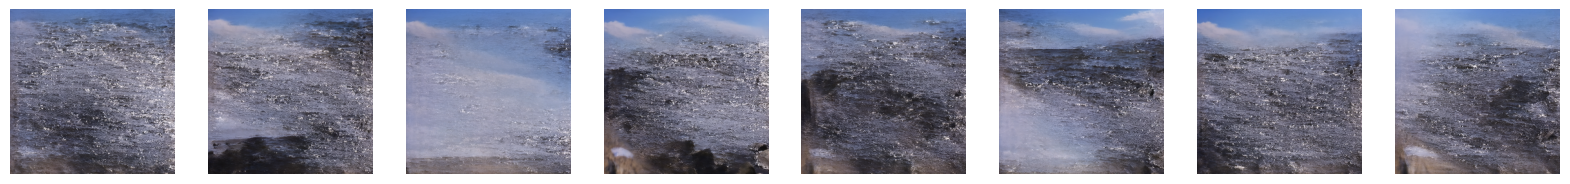

1888/1888 [==============================] - 1322s 695ms/step - n_loss: 0.0633


In [33]:
# run training and plot generated images periodically

# model_checkpoint_callback = callbacks.ModelCheckpoint(
#     filepath="./checkpoint/checkpoint.ckpt",
#     save_weights_only=True,
#     save_freq="epoch",
#     verbose=0,
# )

checkpoint_filepath = './checkpoint/checkpoint.weights.tf'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generate(
            num_images=self.num_img,
            diffusion_steps=PLOT_DIFFUSION_STEPS,
        ).numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


image_generator_callback = ImageGenerator(num_img=10)

ddm.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

## 4. Inference <a name="inference"></a>

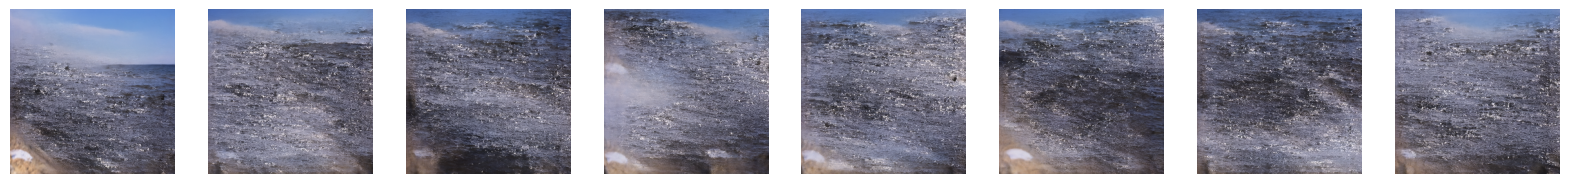

In [34]:
# Generate some novel images
generated_images = ddm.generate(num_images=10, diffusion_steps=20).numpy()
display(generated_images)

# Save images as png files
for i in range(len(generated_images)):
    img = utils.array_to_img(generated_images[i])
    img.save("./output/generated_img_inference_%02d.png" % (i))

In [28]:
# View improvement over greater number of diffusion steps
# for diffusion_steps in list(np.arange(1, 6, 1)) + [20] + [100]:
#     tf.random.set_seed(42)
#     generated_images = ddm.generate(
#         num_images=10,
#         diffusion_steps=diffusion_steps,
#     ).numpy()
#     display(generated_images)

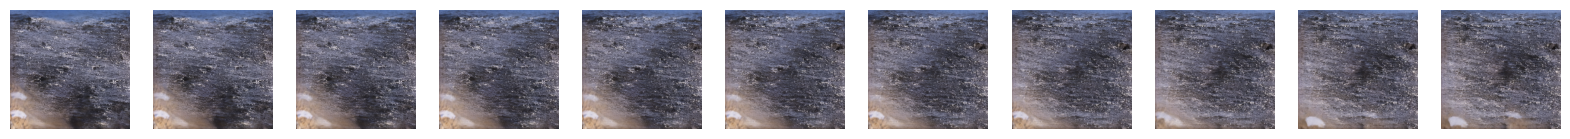

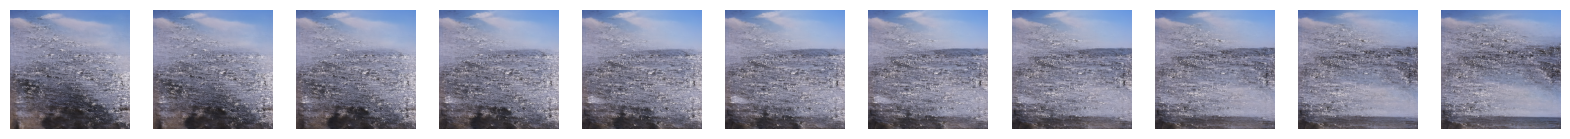

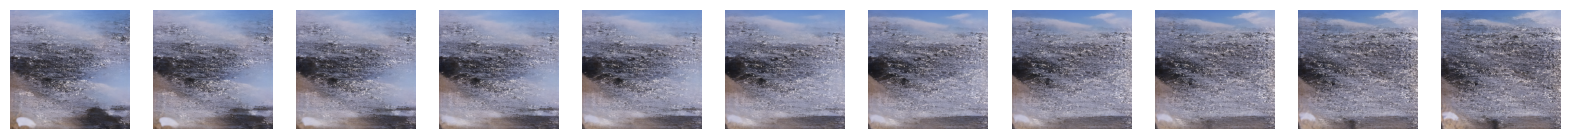

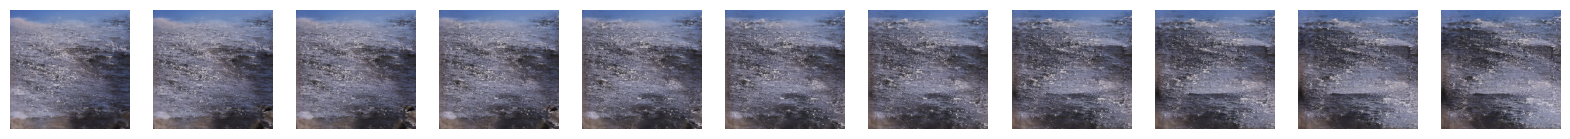

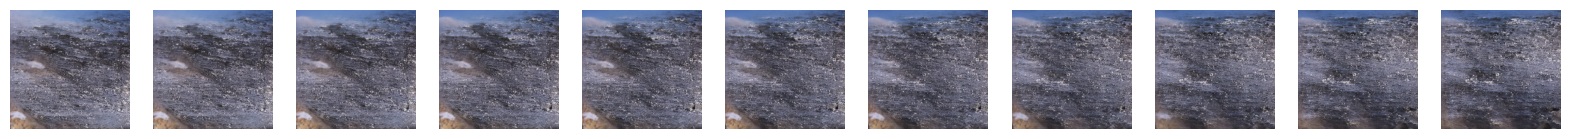

In [35]:
# Interpolation between two random points in the latent space
tf.random.set_seed(100)


def spherical_interpolation(a, b, t):
    return np.sin(t * math.pi / 2) * a + np.cos(t * math.pi / 2) * b


for i in range(5):
    a = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    b = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    initial_noise = np.array(
        [spherical_interpolation(a, b, t) for t in np.arange(0, 1.1, 0.1)]
    )
    generated_images = ddm.generate(
        num_images=2, diffusion_steps=20, initial_noise=initial_noise
    ).numpy()
    display(generated_images, n=11)

# Interpolation
* Generate two consistent and different pictures.
* Save the pictures as a file.
* Regenerate the same pictures.
* Interpolate in latent space between pictures.

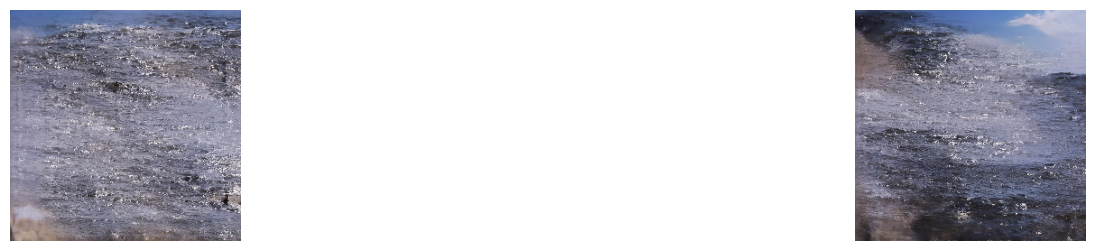

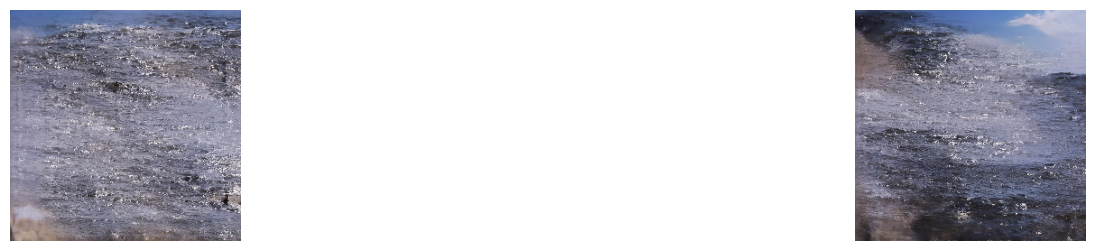

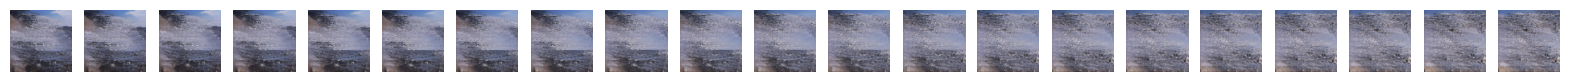

In [36]:
# Generate a noise sample from a normal distribution
# low tide seeds: 4, 6, 11, 29, 90
# High tide seeds: 5, 70
tf.random.set_seed(18)
n1 = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
tf.random.set_seed(5)
n2 = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Stack the two arrays, adding a batch dimension
n = np.stack((n1, n2), axis=0)

# Generate the image
generated_image = ddm.generate(
    num_images=2, diffusion_steps=20, initial_noise=n
).numpy()

# Look at the image
display(generated_image, n=2)

# Save the noise distributions as a file
with open("n.npy", "wb") as file:
    np.save(file, n1)
    np.save(file, n2)
    
# Load the noise distributions from the file
with open('n.npy', 'rb') as file:
    f_n1 = np.load(file)
    f_n2 = np.load(file)

# Stack the distributinos together, adding a batch dimension
f_n = np.stack((f_n1, f_n2), axis=0)

# Generate images
loaded_image = ddm.generate(
    num_images=2, diffusion_steps=20, initial_noise=f_n
).numpy()

# Look at the image from file
display(loaded_image, n=2)

# Interpolate between the two images in latent space
initial_noise = np.array(
    [spherical_interpolation(n1, n2, t) for t in np.arange(0, 1.1, 0.05)]
)

interpolated_images = ddm.generate(
    num_images=None, diffusion_steps=20, initial_noise=initial_noise
).numpy()

# display(interpolated_images, n=11)
display(interpolated_images, n=21)

# Save images as png files
for i in range(len(interpolated_images)):
    img = utils.array_to_img(interpolated_images[i])
    img.save("./output/interpolated_img_inference_%02d.png" % (i))